In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
pd.options.display.width = 200

In [2]:
# chart data読み込み
# chart name
chart="USDJPY"

# csvファイル読み込み
file_path = f"../../charts/{chart}/one-hours/{chart}_all.csv"
all_chart_data = pd.read_csv(file_path)
print(all_chart_data)

             date   time     open     high      low    close  volume
0      2015.01.02  00:00  119.743  119.843  119.699  119.820     179
1      2015.01.02  01:00  119.820  119.967  119.803  119.884     874
2      2015.01.02  02:00  119.884  120.073  119.836  120.071     601
3      2015.01.02  03:00  120.071  120.421  120.048  120.278    1088
4      2015.01.02  04:00  120.278  120.427  120.260  120.359     666
...           ...    ...      ...      ...      ...      ...     ...
18306  2023.04.28  19:00  135.994  136.100  135.957  136.074    8016
18307  2023.04.28  20:00  136.075  136.205  136.043  136.171    5970
18308  2023.04.28  21:00  136.172  136.290  136.150  136.256    8163
18309  2023.04.28  22:00  136.256  136.258  136.141  136.238    5856
18310  2023.04.28  23:00  136.236  136.347  136.199  136.299    5006

[18311 rows x 7 columns]


In [3]:
print(all_chart_data.dtypes)

date       object
time       object
open      float64
high      float64
low       float64
close     float64
volume      int64
dtype: object


In [4]:
# 移動平均と乖離率と上昇度計算
# 60時間移動平均と乖離率
moving_60_ave = [None]*59
deviation_rate = [None]*59

for i in range(59, len(all_chart_data)):
    ave = all_chart_data["close"][i-59:i+1].mean()
    dev = all_chart_data.iloc[i][5]/ave
    moving_60_ave.append(ave)
    deviation_rate.append(dev)

all_chart_data["moving_60_ave"]=moving_60_ave
all_chart_data["deviation_rate"]=deviation_rate

print(all_chart_data)

             date   time     open     high      low    close  volume  moving_60_ave  deviation_rate
0      2015.01.02  00:00  119.743  119.843  119.699  119.820     179            NaN             NaN
1      2015.01.02  01:00  119.820  119.967  119.803  119.884     874            NaN             NaN
2      2015.01.02  02:00  119.884  120.073  119.836  120.071     601            NaN             NaN
3      2015.01.02  03:00  120.071  120.421  120.048  120.278    1088            NaN             NaN
4      2015.01.02  04:00  120.278  120.427  120.260  120.359     666            NaN             NaN
...           ...    ...      ...      ...      ...      ...     ...            ...             ...
18306  2023.04.28  19:00  135.994  136.100  135.957  136.074    8016     134.183167        1.014091
18307  2023.04.28  20:00  136.075  136.205  136.043  136.171    5970     134.225433        1.014495
18308  2023.04.28  21:00  136.172  136.290  136.150  136.256    8163     134.268600        1.014802


231


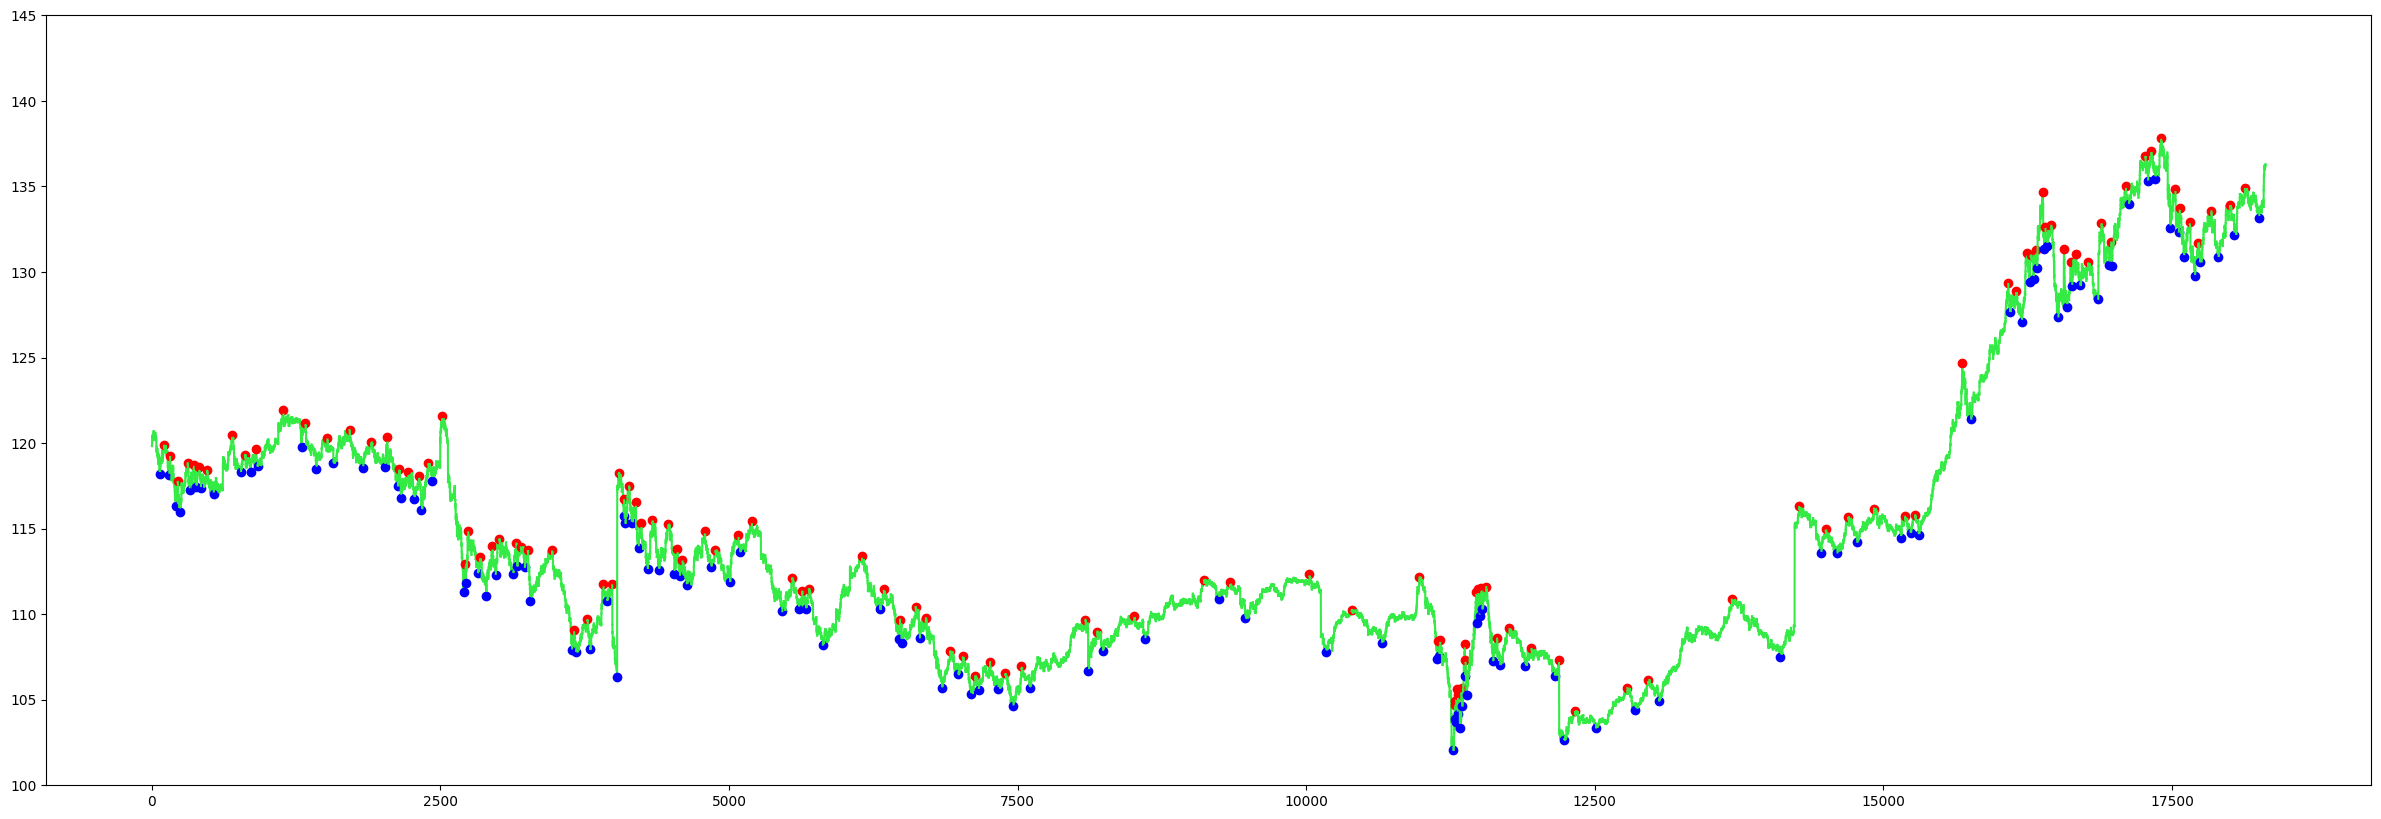

In [5]:
# 天井度計算

# sp波動法用param
sp = 0.8
sp_top = (200 + sp)/(200 - sp)
sp_bottom = (200 - sp)/(200 + sp)

#最大のcloseのindexと値
max_close_index = all_chart_data.index.get_loc(all_chart_data["close"].idxmax())
max_close_value = all_chart_data["close"].max()

top = max_close_value
bottom = 0
phase = 0
state = "bottom"
top_and_bottom = [[all_chart_data["close"].idxmax(), all_chart_data["close"].max(),1]]

for i in range(max_close_index, -1, -1):
    a = all_chart_data["close"][i]
    if(state == "top"):
        if(a > bottom*sp_top):
            state = "bottom"
            top = a
            top_and_bottom.append([all_chart_data.index[i], i, 1])
        elif(a <= bottom):
            bottom = a
            top_and_bottom.pop()
            top_and_bottom.append([all_chart_data.index[i], i, -1])
    elif(state == "bottom"):
        if(a < top*sp_bottom):
            state = "top"
            bottom = a
            top_and_bottom.append([all_chart_data.index[i], i, -1])
        elif(a >= top):
            top = a
            top_and_bottom.pop()
            top_and_bottom.append([all_chart_data.index[i], i, 1])
            
print(len(top_and_bottom))
top_and_bottom.reverse()

phase = 0
state = "bottom"
top = all_chart_data["close"].max()

for i in range(max_close_index, len(all_chart_data["close"]), 1):
    a = all_chart_data["close"][i]
    if(state == "top"):
        if(a > bottom*sp_top):
            state = "bottom"
            top = a
            top_and_bottom.append([all_chart_data.index[i], i, 1])
        elif(a <= bottom):
            bottom = a
            top_and_bottom.pop()
            top_and_bottom.append([all_chart_data.index[i], i, -1])
    elif(state == "bottom"):
        if(a < top*sp_bottom):
            state = "top"
            bottom = a
            top_and_bottom.append([all_chart_data.index[i], i, -1])
        elif(a >= top):
            top = a
            top_and_bottom.pop()
            top_and_bottom.append([all_chart_data.index[i], i, 1])
            
top_and_bottom.pop(0)
top_and_bottom.pop()

pointer_top = []
pointer_bottom = []
for i, v in enumerate(all_chart_data["close"]):
    pointer_top.append(-1)
    pointer_bottom.append(-1)
for i, v in enumerate(top_and_bottom):
    if(v[2]==-1):
        pointer_bottom[v[1]] = all_chart_data["close"][v[1]]
    else:
        pointer_top[v[1]] = all_chart_data["close"][v[1]]
        
    


# 表示
fig = plt.figure(figsize=(30,10))
plt.ylim(100,145)
plot_length = len(all_chart_data)-1
for i in range(plot_length):
    plt.plot(range(plot_length+1)[i:i+2], all_chart_data["close"][i:i+2], color="#34eb46")
    plt.plot(range(plot_length+1)[i], pointer_bottom[i], linestyle='None', marker='o' if pointer_bottom[i] != -1 else "None" ,color="b")
    plt.plot(range(plot_length+1)[i], pointer_top[i],    linestyle='None', marker='o' if pointer_top[i]    != -1 else "None" ,color="r")
plt.show()


             date   time     open     high      low    close  volume  moving_60_ave  deviation_rate  rise_rate
0      2015.01.02  00:00  119.743  119.843  119.699  119.820     179            NaN             NaN         -1
1      2015.01.02  01:00  119.820  119.967  119.803  119.884     874            NaN             NaN         -1
2      2015.01.02  02:00  119.884  120.073  119.836  120.071     601            NaN             NaN         -1
3      2015.01.02  03:00  120.071  120.421  120.048  120.278    1088            NaN             NaN         -1
4      2015.01.02  04:00  120.278  120.427  120.260  120.359     666            NaN             NaN         -1
...           ...    ...      ...      ...      ...      ...     ...            ...             ...        ...
18306  2023.04.28  19:00  135.994  136.100  135.957  136.074    8016     134.183167        1.014091          1
18307  2023.04.28  20:00  136.075  136.205  136.043  136.171    5970     134.225433        1.014495          1
1

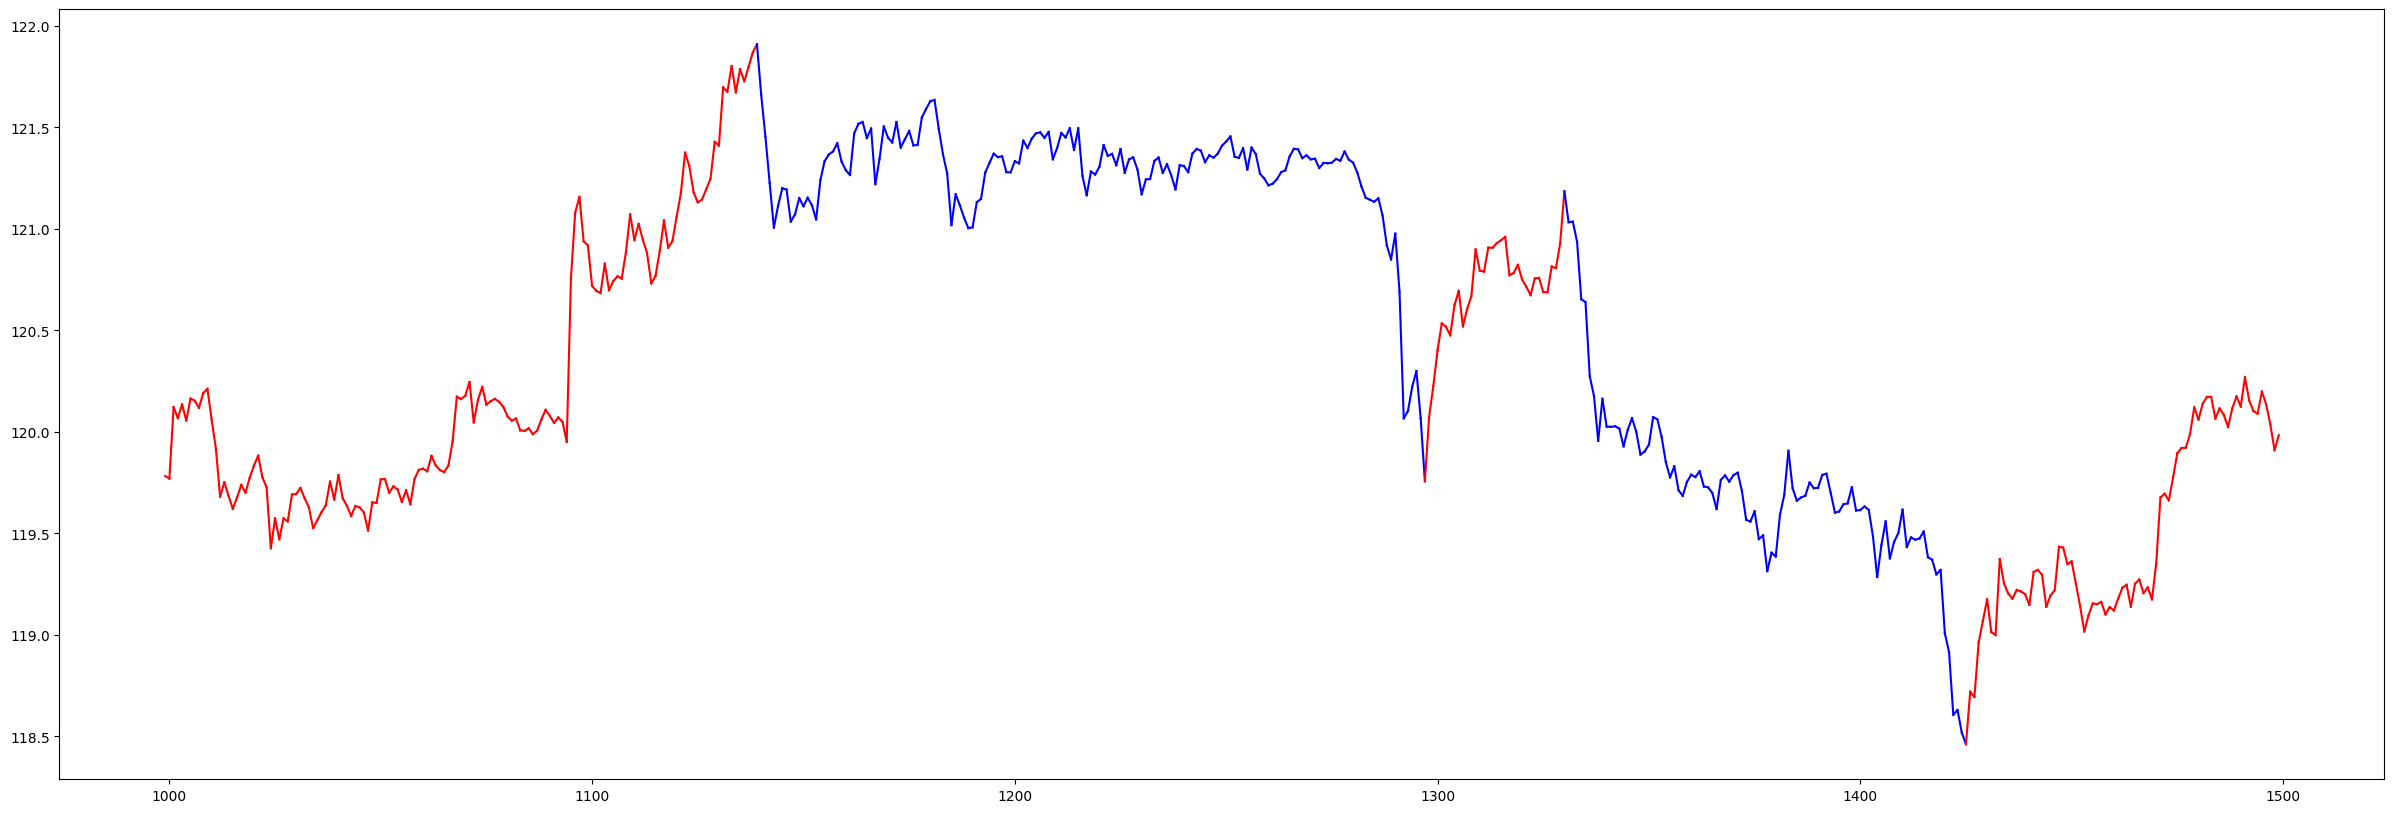

In [6]:
# 上昇度計算
all_chart_data["rise_rate"] =1 if top_and_bottom[-1][2]==-1 else -1
for i, v in enumerate(top_and_bottom):
    if(i == 0):
        all_chart_data.loc[:v[1], "rise_rate"] = v[2]
    else:
        all_chart_data.loc[top_and_bottom[i-1][1]:v[1], "rise_rate"] = v[2]
print(all_chart_data)
# 表示
fig = plt.figure(figsize=(30,10))
plot_length = len(all_chart_data)-1
for i in range(1000, 1500):
    plt.plot(range(plot_length+1)[i-1:i+1], all_chart_data["close"][i-1:i+1], color= 'red' if all_chart_data["rise_rate"][i-1] == 1 else 'blue')
plt.show()

In [7]:
# 作成した結果を保存
# 無ければ保存先ディレクトリ作成
from pathlib import Path
dir_path = f"./target"
dir = Path(dir_path)
dir.mkdir(parents=True, exist_ok=True)

# 保存
save_path = f"{dir_path}/target_{chart}.csv"
all_chart_data.to_csv(save_path, index=False)